# Why am I applying for this job?

Always striving for efficiency leaves a person with many opportunities for optimization. I wanted a way to separate jobs seeking a "learning machinist" from a person who is using "machine learning" or the expert in Excel analytics from the billion row data miner. The following python code is an attempt to separate the wheat from the chaff.


The data set was built by polling the indeed API for the following search terms (and in the DFW area): "machine learning", "technology", "AI", "director technology", "data mining", 
"research technology", "data scientist", "python", "business analytics" See "indeedfetch.py" for libraries used. All of the below is with the assumption a document database of job postings is already built and avaiable. 

### 1.0 Setup & Housekeeping Functions

###### (Skip reading this section, it's just prerequisite code)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.rc('font',family='serif')

from pymongo import MongoClient

from bs4 import BeautifulSoup

import os, warnings, pprint, re
from collections import Counter, defaultdict
from datetime import date, timedelta
from itertools import product
from string import punctuation

import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series, to_datetime

from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import cross_validation, feature_extraction, grid_search, feature_selection
from sklearn import metrics, naive_bayes, pipeline, tree
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
pp = pprint.PrettyPrinter(indent=1, width=80)

def top20_by_cluster(i, label):
    """ raw text summary """
    if i == 0:
        print()
        print('Group (Cluster) of primary interest: ' + str(maxCluster4[0]))
        print()
    s = str()
    for d in short_jobDataFrame.desc[short_jobDataFrame[label] == i]:
        s += str(' ' + d).lower()
    print('---------------------------------------')
    print("--- Group number: " + str(i))
    print('---------------------------------------')
    print('--- Top Words by Occurrence')
    print('---------------------------------------')
    word_fd = FreqDist([w for w in word_tokenize(s) \
                        if not w in stopwords.words('english') \
                        and w not in punctuation])
    for w in word_fd.most_common(9):
        if str(w[0]) != '...': # special case of not punctuation
            pp.pprint(str(w[0]) + ': ' + str(w[1]))
    print('---------------------------------------')
    print('--- Top Bi-Grams:')
    print('---------------------------------------')
    grams_fd = ngrams([w for w in word_tokenize(s) \
                       if not w in stopwords.words('english') \
                       and w not in punctuation], 2)
    for g in FreqDist([w for w in grams_fd \
                       if w[0] != '...' \
                       and w[1] != '...']).most_common(10): # see above
        pp.pprint(str(g[0][0]) + ' ' + str(g[0][1]) + ': ' + str(g[1]))
    print('---------------------------------------')
    print('--- Top Sentences:')
    print('---------------------------------------')
    sent_fd = FreqDist([w for w in sent_tokenize(s)])
    for w in sent_fd.most_common(20):
        if w[1] > 5 and len(w[0]) > 20:
            pp.pprint(w[0] + ': ' + str(w[1]))
    print()
    print()

def label_by_cluster(label, column, count=3):
    """ output job descriptions by column and label """

    for d in short_jobDataFrame.desc[short_jobDataFrame[column] == label][:count]:
        pp.pprint(d)
        print()
        
def dmDistMax(df, title = 'data scientist'):
    """ return most common label with specified job title """

    # subset cluster labels by job title
    c = Counter(df.klab[df.title == title])
    try:
        max_index = c.most_common(1)[0][0]
    except:
        max_index = -1
    return(max_index, c)

In [3]:
# This is included for pedagogical reasons and will differ greatly based on environment 
def setupData():
    """ pull from database and pack into dataframe """
    
    client = MongoClient('localhost', 27020)
    db = client.job
    indeed = db.indeed

    # pull all into lists, to lower, then push to dataframe
    jobCursor = indeed.find()
    element_names = ['jobtitle', 'snippet', 'company', 'date', 'jobkey', 'url']
    dd = defaultdict(list)

    for l in jobCursor[:]:
        # run through the cursor once
        for n in element_names:
            if n == 'date':
                [dd[n].append(j[n]) for j in l['results']]
            elif n == 'snippet':
                [dd[n].append(BeautifulSoup(j[n].lower()).get_text()) for j in l['results']]
            else:
                [dd[n].append(j[n].lower()) for j in l['results']]

    # pack into dataframe
    df = DataFrame({'company': dd['company'],
                'desc': dd['snippet'],
                'url': dd['url'],
                'title': dd['jobtitle'],
                'jobkey': dd['jobkey']},
                index = to_datetime(dd['date']))
    
    # agencies are posting the same jobs with slightly differing descriptions
    # dropped = df.drop_duplicates(subset=['company','desc','title','jobkey'])
    dropped = df.drop_duplicates(subset=['company','jobkey'])
    return(dropped)

### 1.1 Pull in Data From the Database and Store in a DataFrame

In [4]:
jobDataFrame = setupData()

### 1.2 Feature selection methods for clustering
######Decide what we are going to use for dividing the job descriptions into groups 

In [5]:
# Run a randomized search to find a reasonable model
# This is commented out because it takes about 4 hours to run on my computer
#
# I used Silhouette coefficients because a score near 1 indicates that 
# the sample is far away from the neighboring clusters and there aren't 
# native methods for scoring. 
# more info http://blog.data-miners.com/2011/03/cluster-silhouettes.html
# and "Silhouettes: A graphical aid to the interpretation and validation of 
# cluster analysis" doi:10.1016/0377-0427(87)90125-7
#
# add score method to dbscan for (grid/random) search, return 0 for error above
# class Local_DBSCAN(DBSCAN):
#    def score(self, X, y=None):
#        try:
#            s = silhouette_score(X,self.fit(X).labels_)
#        except:
#            s = 0 #work around bug
#            pass
#        return s
#   
# pipe = pipeline.Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english')),
#                          ("ldbscan", Local_DBSCAN())
#                         ])
#
# params = dict(tfidf__use_idf = [True, False],
#               tfidf__smooth_idf = [True, False],
#               tfidf__sublinear_tf = [True, False],
#               tfidf__ngram_range=[(1, 1), (1, 2), (1, 3)],
#               tfidf__norm = ['l1', 'l2'],
#               tfidf__max_features = list(range(2,10)),
#               ldbscan__eps = np.arange(0.1, 0.5, 0.05),
#               ldbscan__min_samples = list(range(10, 26)),
#               ldbscan__leaf_size = list(range(10, 80, 5)),
#              )
#
# random_search = RandomizedSearchCV(pipe,
#                                   param_distributions = params, 
#                                   n_iter = 10000, 
#                                   n_jobs = 4,
#                                   pre_dispatch = 5000)
#
# grid_search = GridSearchCV(pipe, params, n_jobs=4, pre_dispatch=10000)
#
# X = jobDataFrame.desc
#
# time and fit model
#
# import timeit
# tic = timeit.default_timer()
# random_search.fit(X)
# grid_search.fit(X)
# toc = timeit.default_timer()
# run_time = toc - tic
# print("Run took " + str(run_time) + " seconds") #elapsed time in seconds
# Run took 12208.448298786998 seconds about 4 hours
#
# print(random_search.best_estimator_)
# print(random_search.best_score_)
# Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
#         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
#        lowercase=True, max_df=1.0, max_features=2, min_df=1,
#        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
#    1.50000000000006, leaf_size=40,
#       metric='euclidean', min_samples=24, p=None, random_state=None))])
#  0.997036594884

######Math behind Silhouette coefficients:
Let $a(i)$ be the average dissimilarity of $i$ with all other data within the same cluster.

Let $b(i)$ be the lowest average dissimilarity of $i$ to any other cluster, of which $i$ is not a member.

$$ s(i) = \frac{b(i)-a(i)}{max\{a(i), b(i)\}} $$

Therefore $ -1 \le s(i) \le 1 $


For $s(i)$ to be close to 1 we require $a(i) \ll b(i)$. As $a(i$) is a measure of how dissimilar $i$ is to its own cluster, a small value means it is well matched. Furthermore, a large $b(i)$ implies that $i$ is badly matched to its neighboring cluster. 

Note that this is the general form of the formula, see second link above for more information. 

### 1.3 Vectorize - Hyperparamaters Chosen From Random Search
###### Convert text into matrices sutable for DBSCAN and do some cleanup.

In [5]:
# This is based on the above random search.
# Note the very small max_features, this is counter intuative
# the random search suggests that the best clustering can be 
# achieved with only two words. 

tf_vect = TfidfVectorizer(max_features = 2, norm='l1', smooth_idf=True, stop_words = 'english')

X = tf_vect.fit_transform(jobDataFrame.desc)

# The two words are technology and data
# print(tf_vect.vocabulary_)
# {'technology': 1, 'data': 0}

### 2.0 Fit Initial Model Append Results to Data
###### Run the processed data through the first algorithm

In [6]:
# Small epsilon and relatively small minimum samples from grid search above
cluster_mod_fitted = DBSCAN(eps=0.15, min_samples=24).fit(X)

# Append labels column to dataframe
jobDataFrame['klab'] = Series(np.asarray(cluster_mod_fitted.labels_), index=jobDataFrame.index)

print("Clustering produced " + str(len(np.unique(cluster_mod_fitted.labels_))) + " labels")
# Find the data science related label
maxCluster4 = dmDistMax(jobDataFrame)

Clustering produced 5 labels


######Code (pseudocode) behind Density-based spatial clustering of applications with noise:

<code>
DBSCAN(D, eps, MinPts)
   C = 0
   for each point P in dataset D
      if P is visited
         continue next point
      mark P as visited
      NeighborPts = regionQuery(P, eps)
      if sizeof(NeighborPts) < MinPts
         mark P as NOISE
      else
         C = next cluster
         expandCluster(P, NeighborPts, C, eps, MinPts)
</code>
<code>
expandCluster(P, NeighborPts, C, eps, MinPts)
   add P to cluster C
   for each point P' in NeighborPts 
      if P' is not visited
         mark P' as visited
         NeighborPts' = regionQuery(P', eps)
         if sizeof(NeighborPts') >= MinPts
            NeighborPts = NeighborPts joined with NeighborPts'
      if P' is not yet member of any cluster
         add P' to cluster C
</code>
<code>          
regionQuery(P, eps)
   return all points within P's eps-neighborhood (including P)
</code>

See "An Improved Sampling-Based DBSCAN for Large Spatial Databases" (Borah & Bhattacharyya 2004) for more

In [7]:
c = Counter(cluster_mod_fitted.labels_)

# DBSCAN uses a label of '-1' to indicate low confidence / outliers 
short_list = [lab[0] for lab in c.most_common(5) if not lab[0] == -1]

# create a cleaned up initial dataframe 
# a quick check to ensure the data science jobs are in the top 5
if maxCluster4[0] in short_list:
    print("Data Scientist in top 5")
    short_jobDataFrame = jobDataFrame[jobDataFrame.klab.map(lambda x: x in short_list)]

print()
print("Top Clusters" + str(Counter(short_jobDataFrame.klab).most_common(5)))

Data Scientist in top 5

Top Clusters[(0, 2784), (2, 1777), (1, 1229), (3, 114)]


### 2.1 Cleanup and Retag Outliers

In [8]:
# ignore warning that doesn't apply in this case
# http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
pd.options.mode.chained_assignment = None  

# clean up a few missed jobs by retagging
re_search = 'machine learning'
# let's look at what we have for the jobs for a data scientist
cols_df = ['company', 'desc', 'title', 'klab','jobkey']
data_science_title_df = short_jobDataFrame[cols_df][short_jobDataFrame.title == 'data scientist']
# print(data_science_title_df.sort(ascending=False).head())
for f in data_science_title_df.sort(ascending=False).iterrows():
    # company f[1][0], desc f[1][1], title f[1][2], klab f[1][3]
    klab = f[1][3]
    if klab != maxCluster4[0]:
        if re.search(re_search, f[1][1], re.I):
            short_jobDataFrame['klab'][short_jobDataFrame.jobkey == f[1][4]] = maxCluster4[0]

## Verify Results & Plot

### 3.0 Generate Plottable Data

In [9]:
# project vectorized data into a lower dimensional space for plotting
# X_.shape is ~(5437, 6064) before PCA
pca_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),])

# Note this is the raw text data and not what is already vectorized
X_ = pca_pipe.fit_transform(short_jobDataFrame.desc).todense()

# data_2d.shape is ~(5437, 2)
data_2d = PCA(n_components=2).fit_transform(X_)

# pack into dataframe
pca_decomp = pd.DataFrame(data_2d,columns=['x', 'y'])

# append DBSCAN labels for plot coloring
pca_decomp['dbscan_labels'] = Series(short_jobDataFrame.klab.values)

# quick way to calculate cluster centers by label
# x_centers = [np.mean(pca_decomp['x'][pca_decomp['dbscan_labels'] == l]) for l in np.unique(pca_decomp['dbscan_labels'])]
# y_centers = [np.mean(pca_decomp['y'][pca_decomp['dbscan_labels'] == l]) for l in np.unique(pca_decomp['dbscan_labels'])]

### 3.1 We can see the 4 distinct clusters in the plot. The smallest cluster is loosely defined.

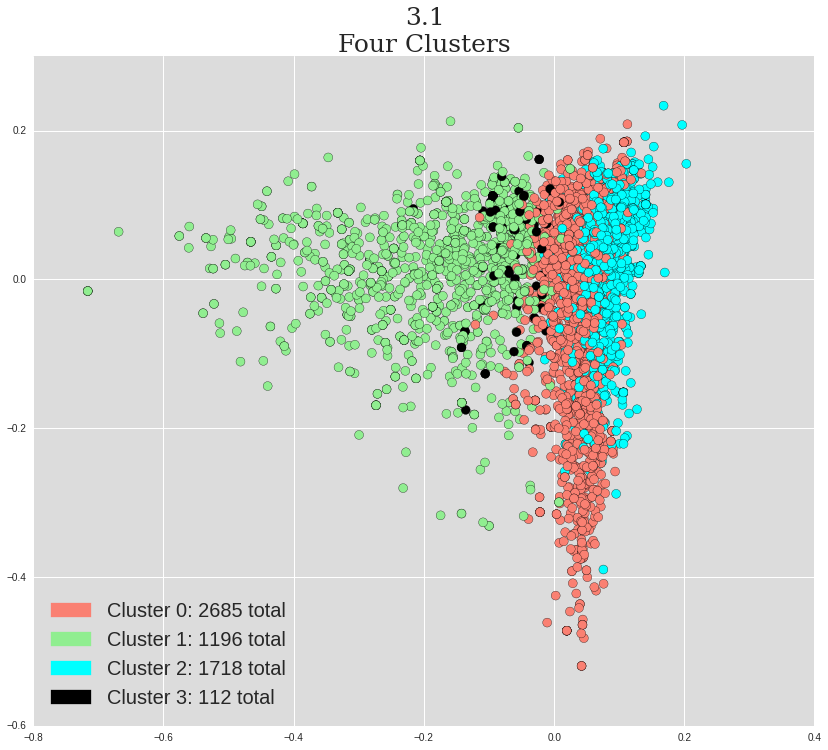

In [11]:
# generate a plot based on 2d data and color by DBSCAN labels to see the clustering
# plot setup
fig = plt.figure(figsize=(14,12))
cmap_list = ['salmon', 'lightgreen', 'aqua', 'k']
cmap = ListedColormap(cmap_list)
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('gainsboro')
ax.set_title('3.1\nFour Clusters(Groups)', fontsize=25, family='serif')
ax.scatter(pca_decomp['x'].values,
           pca_decomp['y'].values,
           c = pca_decomp['dbscan_labels'],
           cmap = cmap,
           s=80,
           )
# Patches for legend
klab_totals = Counter(short_jobDataFrame.klab)
patch_0 = mpatches.Patch(color=cmap.colors[0],
                         label='Cluster 0: {} total'.format(klab_totals[0]))
patch_1 = mpatches.Patch(color=cmap.colors[1],
                         label='Cluster 1: {} total'.format(klab_totals[1]))
patch_2 = mpatches.Patch(color=cmap.colors[2],
                         label='Cluster 2: {} total'.format(klab_totals[2]))
patch_3 = mpatches.Patch(color=cmap.colors[3],
                         label='Cluster 3: {} total'.format(klab_totals[3]))
ax.legend(handles=[patch_0, patch_1, patch_2, patch_3], fontsize=20, loc=3)

### 3.2 Review Several Samples

In [12]:
# output job descriptions by group / cluster
for i in range(4):
    print('\x1b[1;31m'+'Group ' + str(i)+'\x1b[0m')
    label_by_cluster(i, 'klab')

Group 0
'operate office machines, such as photocopiers and scanners, facsimile '
'machines, voice mail systems and personal computers....'

'assume responsibility for learning and adapting to each student’s special '
'medical, physical, communicative, and emotional needs....'

'prime or troubleshoot dialysis machine issues, involve biomed tech when '
'needed. assess patient and family learning needs formulating a patient '
'teaching plan....'

Group 1
'machine learning and unstructured data. creates user information solutions '
'for complex and large programs by developing, implementing, and maintaining '
'java...'

'data mining and machine learning algorithms – e.g. classification, '
'clustering, logistic regression. knowledge of data mining, predictive '
'analytics and machine...'

'strong knowledge of excel and/or data mining tools such as access, sql, or '
'sas. summary of responsibilities:....'

Group 2
'experience working with fax machines, computer software, and telephone '
'tec

In [13]:
# verify job clustering
# note that the smallest cluster is really a blend of medical jargon with some technology terms

# generate job summaries by cluster label generated by DBSCAN
for n in range(4):
    top20_by_cluster(n, 'klab')


Group (Cluster) of primary interest: 1

---------------------------------------
--- Group number: 0
---------------------------------------
--- Top Words by Occurrence
---------------------------------------
'business: 863'
'python: 577'
'technologies: 562'
'experience: 545'
'research: 476'
'director: 366'
'development: 310'
'learning: 245'
---------------------------------------
--- Top Bi-Grams:
---------------------------------------
'perl python: 108'
'years experience: 86'
'new technologies: 73'
'job description: 67'
'machine learning: 59'
'python perl: 51'
'python ruby: 47'
'experience python: 45'
'business process: 45'
'java python: 43'
---------------------------------------
--- Top Sentences:
---------------------------------------
'extensive programming experience in python.: 18'
'computers, fax and copier machines.: 10'
'providing industry best ci/cd to openstack/python projects.: 7'


---------------------------------------
--- Group number: 1
-----------------------------

### 3.3 I'm really only interested in two Categories, jobs I want and jobs I do not want. 

In [14]:
# relabel jobs into two categories
binary_labs = []
for lab in short_jobDataFrame['klab'].values:
    if lab == maxCluster4[0]:
        binary_labs.append(1)
    else:
        binary_labs.append(0)
short_jobDataFrame['binary_lab'] = Series(np.asarray(binary_labs), index=short_jobDataFrame.index)

### 3.4 Samples From Each of the Above Clusters

In [15]:
# let's look at what we have for the jobs we care about
short_jobDataFrame[['title','desc']][short_jobDataFrame.binary_lab == maxCluster4[0]].sort(ascending=False).head()

,title,desc
2015-06-01 13:31:20,master system integrator (usa),analyze system and data issues including leadi...
2015-06-01 12:29:55,project lead information management,job description minimum experience required: 5...
2015-06-01 11:28:17,sr. financial reporting analyst,prior experience working with mining and analy...
2015-06-01 07:14:57,etl development lead - data management & analy...,etl development lead - data management & analy...
2015-05-31 13:21:15,sr. data analyst (usa),initiate data mining and analysis activities t...


In [16]:
# let's look at what we have for the jobs we DO NOT care about
short_jobDataFrame[['title','desc']][short_jobDataFrame.binary_lab != maxCluster4[0]].sort(ascending=False).head()

,title,desc
2015-06-01 15:26:17,support desk analyst,fischer & company is a leading corporate real ...
2015-06-01 15:13:45,automation engineer,title: automation engineer position type: 6 mo...
2015-06-01 14:49:36,it operations center analyst,an associate’s (2-year) degree in information ...
2015-06-01 14:10:35,open stack developer,"telco cloud, python scripting. python, shell s..."
2015-06-01 14:02:00,assembler/filler,inserts components into bags or containers per...


### 4.0 Evaluate Several Models

In [17]:
# derived class needed to allow Gaussian NB with sparse data
class ToDensePipe(object):
    def fit(self, X, y=None):
        pass
    def fit_transform(self, X, y=None):
        return self.transform(X)
    def transform(self, X, y=None):
        return X.toarray()

# use newly created binary labels
X_train, X_test, y_train, y_test = cross_validation.train_test_split(short_jobDataFrame.desc,
                                                    short_jobDataFrame.binary_lab,
                                                    test_size=0.2,
                                                    random_state=42)

# GaussianNB
pipe_gauss = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ('densify', ToDensePipe()), # see above
                          ("gauss", naive_bayes.GaussianNB())
                         ])
pipe_gauss.fit(X_train, y_train)
gaussian_Naive_Bayes = metrics.accuracy_score(pipe_gauss.predict(X_test), y_test)

# MultinomialNB
pipe_multi = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("multi", naive_bayes.MultinomialNB())
                         ])
pipe_multi.fit(X_train, y_train)
multinomial_model = metrics.accuracy_score(pipe_multi.predict(X_test), y_test)

# BernoulliNB
pipe_bern = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("bernoulli", naive_bayes.BernoulliNB())
                         ])
pipe_bern.fit(X_train, y_train)
multivariate_bernoulli_model = metrics.accuracy_score(pipe_bern.predict(X_test), y_test)

# Logistic Regression aka maxent
pipe_logreg = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("logreg", LogisticRegression(multi_class='ovr'))
                         ])
pipe_logreg.fit(X_train, y_train)
logistic_regression_model = metrics.accuracy_score(pipe_logreg.predict(X_test), y_test)

print("GaussianNB = {}\nMultinomialNB = {}\nBernoulliNB = {}\nLogistic Regression = {} ".format(
    np.round(gaussian_Naive_Bayes, 2),
    np.round(multinomial_model, 2),
    np.round(multivariate_bernoulli_model, 2),
    np.round(logistic_regression_model, 2),
        )
      )

GaussianNB = 0.8
MultinomialNB = 0.88
BernoulliNB = 0.96
Logistic Regression = 0.96 


######Math behind a multi-variate Bernoulli Model:

In the multi-variate Bernoulli event model, a document is a binary vector over the space of words. Given a vocabulary $V$ , each dimension of the space $t, t ∈ \{1,..., |V |\}$, corresponds to word $w_t$ from the vocabulary. Dimension $t$ of the vector for document $d_i$ is written $B_{it}$, and is either 0 or 1, indicating whether word $w_t$ occurs at least once in the document. With such a document representation, we make the naive Bayes assumption: that the probability of each word occurring in a document is independent of the occurrence of other words in a document. Then, the probability of a document given its class from Equation 1 is simply the product of the probability of the attribute values over all word attributes (McCallum, & Nigam 1998):
$$ P(d_i|C_j;\theta) \prod\limits_{t=1}^{|v|}(B_{it}P(w_y|c_j;\theta) + (1 - B_{it})(1-P(w_t|c_j;\theta))) $$


###### Bernoulli Naive Bayes classifier and Logistic Regression are winners; let's optimize hyperparamaters.

### 4.1 Train, Test, Evaluate

In [18]:
# build a baseline before parameter optimization 
pipe = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("bernoulli", naive_bayes.BernoulliNB()),
                         ])
# fit pipe
pipe.fit(X_train, y_train)

# same accuracy as above
# metrics.accuracy_score(pipe.predict(X_test), y_test)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

### 4.2 Confusion Matrix for Baseline

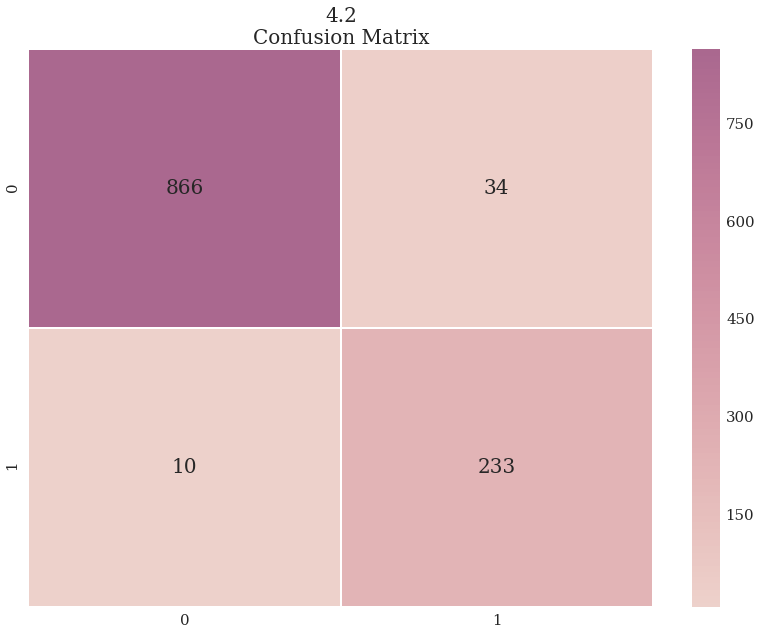

In [19]:
# Seaborn has nice looking heatmap
sns.set(font='serif')
plt.figure(figsize=(14, 10))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(metrics.confusion_matrix(pipe.predict(X_test), y_test),
            annot=True,
            fmt='',
            cmap=sns.cubehelix_palette(8, dark=0.5, as_cmap= True),
            annot_kws={"size": 20},
            )
plt.title('4.2\nConfusion Matrix', size=20)

In [20]:
# add new labels to dataframe
short_jobDataFrame['nb_lab'] = pipe.predict(short_jobDataFrame.desc)

In [21]:
# hyperparamaters for grid search pipe
params = dict(vect__max_df=[0.5, 1.0],
              vect__max_features = range(2,26),
              vect__ngram_range = [(1, 1), (1, 2)],
              vect__stop_words = ['english', None],
              tfidf__use_idf = [True, False],
              tfidf__norm = ['l1', 'l2'],
              bernoulli__alpha = [0, .5, 1],
              bernoulli__binarize = np.arange(0.1, 1, 0.05),
              bernoulli__fit_prior = [True, False],
             )
# number of iterations 
n_iter_search = 100
random_search = grid_search.RandomizedSearchCV(pipe,
                                               param_distributions = params,
                                               n_jobs = 4, # depends on cores
                                               n_iter = n_iter_search)

### 5.0 Run Random Search

In [22]:
# run grid search and save the best estimator in one step
best_pipe = random_search.fit(X_train, y_train).best_estimator_

metrics.accuracy_score(best_pipe.predict(X_test), y_test)

0.99825021872265962

### 5.1 Confusion Matrix for Best Pipline

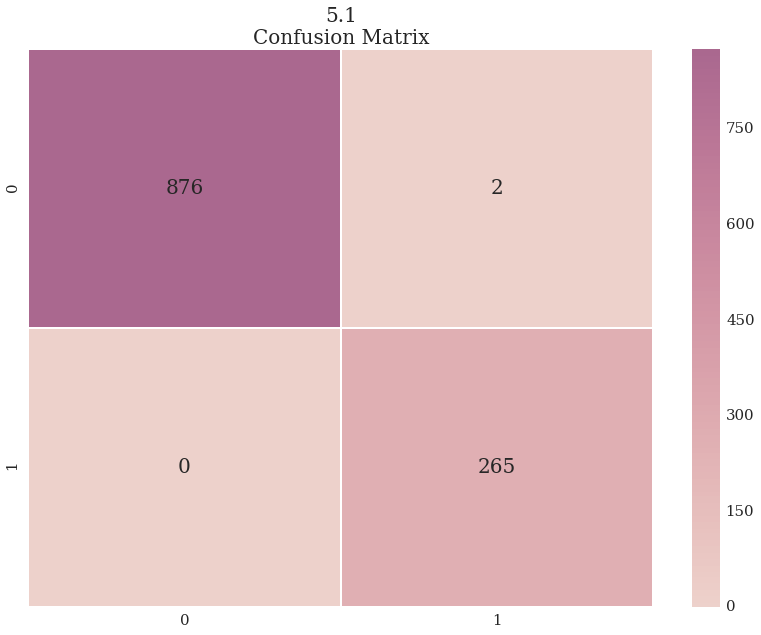

In [23]:
sns.set(font='serif')
plt.figure(figsize=(14, 10))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(metrics.confusion_matrix(best_pipe.predict(X_test), y_test),
            annot=True,
            fmt='',
            cmap=sns.cubehelix_palette(8, dark=0.5, as_cmap= True),
            annot_kws={"size": 20},
            )
plt.title('5.1\nConfusion Matrix', size=20)

### 5.2 Classification Report for Best Pipline

In [24]:
best_pipe = random_search.best_estimator_
# same information as above
# print(metrics.classification_report(best_pipe.predict(X_test), y_test))

In [25]:
# add new prediction column based on the best pipline
short_jobDataFrame['bestklab'] = best_pipe.predict(short_jobDataFrame.desc)
# use decomp with new labels
pca_decomp['best_nb_labels'] = Series(short_jobDataFrame.bestklab.values)

###### We can see two clusters in plot 5.2, The smallest cluster is on the border ling and has been tagged as the uninteresting group.

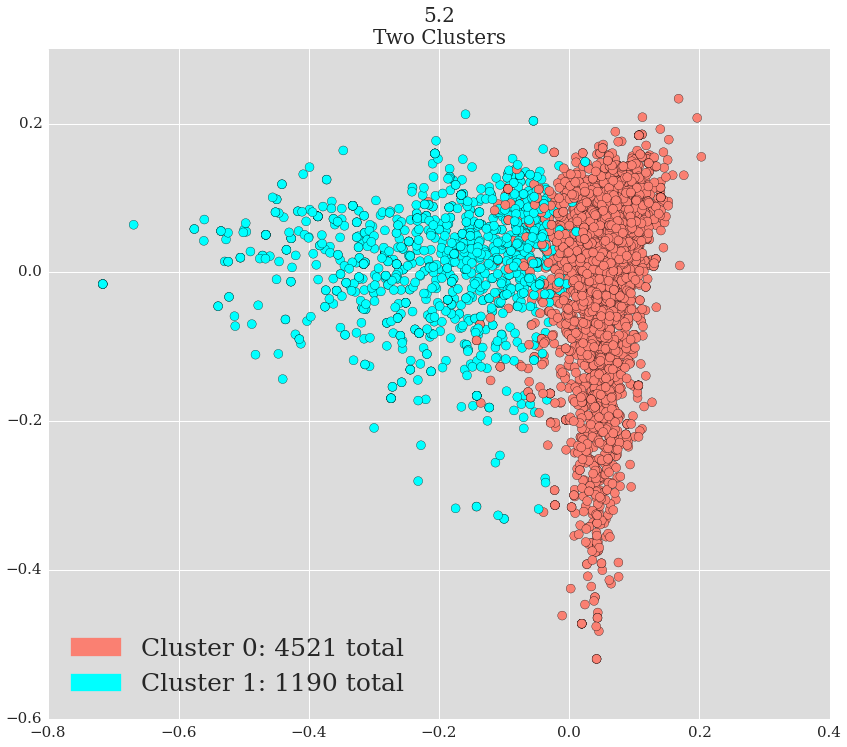

In [26]:
# note that we are using the same PCA data and just coloring points by the new labels
fig = plt.figure(figsize=(14,12))
cmap_list = ['salmon', 'aqua']
cmap = ListedColormap(cmap_list)
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('gainsboro')
ax.set_title('5.2\nTwo Clusters', fontsize=20)
ax.scatter(pca_decomp['x'].values,
           pca_decomp['y'].values,
           c = pca_decomp['best_nb_labels'],
           cmap = cmap,
           s=80,
           )

# add cluster labels to patches

bestklab_totals = Counter(short_jobDataFrame.bestklab)
patch_0 = mpatches.Patch(color=cmap.colors[0],
                         label='Cluster 0: {} total'.format(bestklab_totals[0]))
patch_1 = mpatches.Patch(color=cmap.colors[1],
                         label='Cluster 1: {} total'.format(bestklab_totals[1]))
ax.legend(handles=[patch_0, patch_1], fontsize=25, loc=3)

In [27]:
# generate job summaries by cluster
for n in range(2):
    top20_by_cluster(n, 'bestklab')


Group (Cluster) of primary interest: 1

---------------------------------------
--- Group number: 0
---------------------------------------
--- Top Words by Occurrence
---------------------------------------
'technology: 2337'
'business: 1168'
'experience: 838'
'technologies: 778'
'research: 763'
'director: 642'
'python: 602'
'information: 544'
---------------------------------------
--- Top Bi-Grams:
---------------------------------------
'information technology: 374'
'years experience: 148'
'perl python: 113'
'new technologies: 99'
'technology solutions: 79'
'job description: 71'
'machine learning: 67'
'bachelor’s degree: 64'
'business process: 58'
'research development: 57'
---------------------------------------
--- Top Sentences:
---------------------------------------
'extensive programming experience in python.: 18'
'what happens when you combine technology with travel?...: 17'
'these technologies include cloud computing, software (saa.: 17'
'completion of two (2) years of col

In [28]:
# Group 1 is definitely what I'm interested in
for i in range(4):
    print('\x1b[1;31m'+'Group ' + str(i)+'\x1b[0m')
    label_by_cluster(i, 'bestklab', 10)

Group 0
'operate office machines, such as photocopiers and scanners, facsimile '
'machines, voice mail systems and personal computers....'

'assume responsibility for learning and adapting to each student’s special '
'medical, physical, communicative, and emotional needs....'

'prime or troubleshoot dialysis machine issues, involve biomed tech when '
'needed. assess patient and family learning needs formulating a patient '
'teaching plan....'

'qualifications eight years edi ec b2b experience as an edi business analyst '
'excellent knowledge of ai mapping requirements experience with x12, '
'edifact,...'

'capital one, a fortune 500 company and one of the nation’s top 10 banks, '
'offers a broad spectrum of financial products and services to consumers, '
'small'

'are you a passionate leader with a pulse on innovative technologies and '
'solutions? a seasoned it project manager, with full software lifecycle '
'expertise? at'

'computer, printer, copier, fax machine, multi-line telephon

# Summary of Conclusions

I started this project several months ago by simply automating the data collection. The Indeed API and existing python libraries made it a simple matter to dump into a document database. The goal was to accruatly classify potential jobs without any manual training. Using unsupervised methods to pretrain (with minor tweaks) as input to supervised models has produced good accruacy.


### Screenshot of Matching Job

To make this useful for my job search I take a few more steps. I train on all of the seen data (all jobs since last run). Then classify all new jobs and dump output to html, example result below.

###Screenshot 1.0

<img src="srdata.png">

### Future Directions:

The model is overfitting the data but it's acceptable in this case. In practice one could create a manually adjusted a dataset that was initially clustered by DBSCAN.

Add logistic regression pipe for comparison to Bernoulli pipeline.

This method is applicable to this specific situation, running this of different search terms or with different datasets would require at a minimum the rerunning of grid searches and reevaluating assumptions about the supervised methods.